#### LSTM Model for Limit Order Book 


#### 1: Use DataLoader class to create training and dev data sets from zipped files stored in data folder.

#### 2: Build and compile model using model class based on configuration in config file.

#### 3: Use GenerateBatch class to create itereator to feed batches of sequences of x and y train/val data into model

#### 4: Train model using train_generator method from model class

#### 5: Plot train loss vs val loss

#### 6: Make training and validation predictions using same sequence lengths and batch sizes

#### 7: Compute Precision/Recall/F1 statistics and Cohen Kappa


Changes verus prior version:
1. sequence length increased to 10
2. epochs increased to 25
3. dataset expanded to use 6 training days and 2 val days.


Analysis:
Of these changes, the increase in sequence had the most significant impact. 

Val loss now decreases throughout all epoch.
Cohen Kappa increased dramatically to 53 and 44 for training and dev respectively (from 19 and 13 before).
F1  score increased to 71/63 (from 52/49).


Training time per epoch increased from about 55 seconds to nearly 90 seconds.

Recommendation
Increases in network complexity, sequence length and training time should all be considered.
Moving to GPU enviroment (AWS) at this point is also recommended.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time
import json
%matplotlib inline
# 
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

In [2]:
import os; 
#work-around to allow import from directory on same level
os.sys.path.append(os.path.dirname(os.path.abspath('.')))
from input.DataLoader import DataLoader
from input.GenerateBatch import GenerateBatch
from model.Model import Model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Dropout
from keras.utils import to_categorical
from keras.metrics import categorical_crossentropy
from sklearn.metrics import accuracy_score
from scipy.stats import linregress
from sklearn.utils import shuffle

In [4]:
# recover training and test data from zip files. Provide list of days for each
traindays=[0,1,2,3,4,5] 
valdays=[6,7]

path='data/'
d=DataLoader(path)
traindf=d.get_days(traindays)
valdf=d.get_days(valdays)

# Select X and Y training and dev data. Y is categorical
trainx=traindf.iloc[:,range(40)].values
trainy=to_categorical(traindf.iloc[:,148].values-1)
valx=valdf.iloc[:,range(40)].values
valy=to_categorical(valdf.iloc[:,148].values-1)


In [5]:
print(trainx.shape)
print(trainy.shape)

(217404, 40)
(217404, 3)


In [6]:
configs = json.load(open('config2.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])
print('training',configs['training'])
print('model loss:',configs['model']['loss'])
print('model optimizer:',configs['model']['optimizer'])
print('save dir:',configs['model']['save_dir'])
for i,j in enumerate(configs['model']['layers']):
    print('layer %i' %i)
    print(j)

training {'sequence_length': 10, 'epochs': 25, 'batch_size': 25}
model loss: categorical_crossentropy
model optimizer: adam
save dir: saved_models
layer 0
{'type': 'lstm', 'neurons': 50, 'input_timesteps': 10, 'input_dim': 40, 'return_seq': False}
layer 1
{'type': 'dropout', 'rate': 0.2}
layer 2
{'type': 'dense', 'neurons': 3, 'activation': 'softmax'}


In [7]:
model = Model()
model.build_model(configs)

model.model.summary()

[Model] Model Compiled
Time taken: 0:00:00.228115
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 18,353
Trainable params: 18,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
training_generator=GenerateBatch(trainx,trainy)
#training_generator.GenerateBatch(configs['training']['sequence_length'],configs['training']['batch_size'])
#using same sequence length and batch size for val data 
val_generator=GenerateBatch(valx,valy)
#val_generator.GenerateBatch(configs['training']['sequence_length'],configs['training']['batch_size'])

In [9]:
# out-of memory generative training
#steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
steps_per_epoch =int((trainx.shape[0]-configs['training']['sequence_length'])/configs['training']['batch_size'])
steps_per_epoch_val=int((valx.shape[0]-configs['training']['sequence_length'])/configs['training']['batch_size'])
print(steps_per_epoch,steps_per_epoch_val)

8695 3712


In [10]:
history=model.train_generator(
    train_gen=training_generator.GenerateBatch(configs['training']['sequence_length'],
                                               configs['training']['batch_size']),
    val_gen=val_generator.GenerateBatch(configs['training']['sequence_length'],
                                        configs['training']['batch_size']),
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    save_dir=configs['model']['save_dir']
    )

    

[Model] Training Started
[Model] 25 epochs, 25 batch size, 8695 batches per epoch
Epoch 1/25
 - 86s - loss: 1.0160 - val_loss: 1.0659
Epoch 2/25
 - 85s - loss: 0.9757 - val_loss: 1.0267
Epoch 3/25
 - 84s - loss: 0.9346 - val_loss: 1.0230
Epoch 4/25
 - 84s - loss: 0.9011 - val_loss: 0.9901
Epoch 5/25
 - 85s - loss: 0.8783 - val_loss: 0.9512
Epoch 6/25
 - 85s - loss: 0.8598 - val_loss: 0.9538
Epoch 7/25
 - 84s - loss: 0.8424 - val_loss: 0.9525
Epoch 8/25
 - 84s - loss: 0.8288 - val_loss: 0.9769
Epoch 9/25
 - 84s - loss: 0.8174 - val_loss: 0.9396
Epoch 10/25
 - 84s - loss: 0.8031 - val_loss: 0.9271
Epoch 11/25
 - 84s - loss: 0.7910 - val_loss: 0.9445
Epoch 12/25
 - 84s - loss: 0.7801 - val_loss: 0.8970
Epoch 13/25
 - 85s - loss: 0.7700 - val_loss: 0.8885
Epoch 14/25
 - 84s - loss: 0.7602 - val_loss: 0.9010
Epoch 15/25
 - 84s - loss: 0.7494 - val_loss: 0.9062
Epoch 16/25
 - 85s - loss: 0.7369 - val_loss: 0.8956
Epoch 17/25
 - 85s - loss: 0.7270 - val_loss: 0.8875
Epoch 18/25
 - 84s - loss:

Text(0,0.5,'Cost')

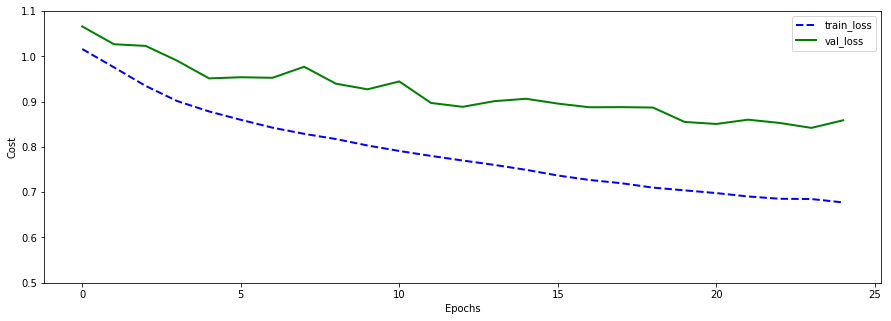

In [19]:

plt.figure(figsize=(15,5))
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
plt.ylim([.5,1.1])
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [12]:
# make our predictions - start from beginning
train_gen=training_generator.GenerateBatch(configs['training']['sequence_length'],configs['training']['batch_size'])
val_gen=val_generator.GenerateBatch(configs['training']['sequence_length'],configs['training']['batch_size'])

In [13]:
y_train=[]
yhat_train=[]
y_val=[]
yhat_val=[]

In [14]:
# predict using same sequence lengths and batches as in training
for i in range(steps_per_epoch):
    dat=next(train_gen)
    y_train.append(dat[1])
    yhat_train.append(model.model.predict(dat[0]))
for i in range(steps_per_epoch_val):
    dat=next(val_gen)
    y_val.append(dat[1])
    yhat_val.append(model.model.predict(dat[0]))
                                            

In [15]:
burn_in=300 # drop early predictions 
y_train=np.array(y_train).reshape(-1,3)[burn_in:]
yhat_train=np.array(yhat_train).reshape(-1,3)[burn_in:]
y_val=np.array(y_val).reshape(-1,3)[burn_in:]
yhat_val=np.array(yhat_val).reshape(-1,3)[burn_in:]


In [16]:
# How well have we done on training data
print ("Training ")
Y=np.argmax(y_train,axis=1)
Yhat=np.argmax(yhat_train,axis=1)
c=confusion_matrix(Y,Yhat)
c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
print(c)
print(classification_report(Yhat,Y))
print("cohen kappa score:",cohen_kappa_score(Yhat,Y))
# How well have we done on test data
print("Test ")
Y=np.argmax(y_val,axis=1)
Yhat=np.argmax(yhat_val,axis=1)
c=confusion_matrix(Y,Yhat)
c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
print(c)
print(classification_report(Yhat,Y))
print("cohen kappa score:",cohen_kappa_score(Yhat,Y))

Training 
[[ 62037   5021  20699  87757]
 [  8946  24945   9006  42897]
 [ 15929   4541  65951  86421]
 [ 86912  34507  95656 217075]]
             precision    recall  f1-score   support

          0       0.71      0.71      0.71     86912
          1       0.58      0.72      0.64     34507
          2       0.76      0.69      0.72     95656

avg / total       0.71      0.70      0.71    217075

cohen kappa score: 0.5319394390438492
Test 
[[21807  2967  9099 33873]
 [ 6654 14593  6662 27909]
 [ 6133  2572 22013 30718]
 [34594 20132 37774 92500]]
             precision    recall  f1-score   support

          0       0.64      0.63      0.64     34594
          1       0.52      0.72      0.61     20132
          2       0.72      0.58      0.64     37774

avg / total       0.65      0.63      0.63     92500

cohen kappa score: 0.44314501975840936
